<a href="https://colab.research.google.com/github/reshalfahsi/semi-supervised-pseudo-labeling/blob/master/Semi_Supervised_Learning_with_Pseudo_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semi-Supervised Learning with Pseudo-Labeling**

## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 163.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 212.8 MB/s eta 0:00:00


### **Import**

In [ ]:
import os
import cv2
import math
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from PIL import Image

from torchvision.models import densenet121
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2 as T

try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics.classification import Accuracy

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 57516732


In [ ]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [ ]:
MAX_EPOCH               = 69
BATCH_SIZE              = 100
LEARNING_RATE           = 2e-3
BASE_LR_SCALE           = 3e-4

## **Dataset**

### **Prepare**

In [ ]:
DATASET_TRANSFORM = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
VALIDATION_INDICES = np.arange(0, 50000, 10)
UNLABELED_INDICES = np.delete(np.arange(50000), VALIDATION_INDICES).tolist()
LABELED_INDICES = np.array([index for index in UNLABELED_INDICES[::45]])
for index in LABELED_INDICES.tolist():
    UNLABELED_INDICES.remove(index)

### **Utils**

In [ ]:
train_dataset = CIFAR10(
    root='experiment/dataset',
    train=True,
    download=True,
    transform=DATASET_TRANSFORM,
)
test_dataset = CIFAR10(
    root='experiment/dataset',
    train=False,
    download=True,
    transform=DATASET_TRANSFORM,
)

100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


Extracting experiment/dataset/cifar-10-python.tar.gz to experiment/dataset
Files already downloaded and verified


### **Load**

In [ ]:
val_dataset = data.Subset(train_dataset, VALIDATION_INDICES)
labeled_dataset = data.Subset(train_dataset, LABELED_INDICES)
unlabeled_dataset = data.Subset(train_dataset, UNLABELED_INDICES)

## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Wrapper**

In [ ]:
class SemiSupervisedModel(L.LightningModule):
    def __init__(self, labeling_model=None):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.lr = LEARNING_RATE
        self.max_epoch = MAX_EPOCH
        self.lr_now = self.lr * 1e3

        self.arch = densenet121(weights="IMAGENET1K_V1")
        self.arch.classifier = nn.Linear(
            self.arch.classifier.in_features,
            10,
        )

        self.labeling_model = labeling_model
        if self.labeling_model:
            self.labeling_model.eval()

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):

        if self.labeling_model is None:
            x, y = batch
            y_hat = self(x)
            y = y.view(y.shape[0])

            loss = F.cross_entropy(y_hat, y)
            self.train_accuracy.update(y_hat.softmax(1), y)
        else:
            labeled, unlabeled = batch

            x_labeled, y_labeled = labeled
            x_unlabeled, _ = unlabeled

            y_hat_labeled = self(x_labeled)
            y_labeled = y_labeled.view(y_labeled.shape[0])

            loss = F.cross_entropy(y_hat_labeled, y_labeled)

            self.train_accuracy.update(y_hat_labeled.softmax(1), y_labeled)

            y_hat_unlabeled = self(x_unlabeled)
            y_unlabeled = self.labeling_model(
                x_unlabeled
            ).detach().softmax(1).argmax(1)
            y_unlabeled = y_unlabeled.view(y_unlabeled.shape[0])

            loss = loss + (
                math.pi * self.current_epoch / self.max_epoch
            ) * F.cross_entropy(
                y_hat_unlabeled, y_unlabeled
            )

            self.train_accuracy.update(y_hat_unlabeled.softmax(1), y_unlabeled)

        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = f"experiment/training/{MODEL_NAME}_acc_plot.png"
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        if self.labeling_model is None:
            return data.DataLoader(
                labeled_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=2,
                persistent_workers=True,
            )

        return [
            data.DataLoader(
                labeled_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=2,
                persistent_workers=True,
            ),
            data.DataLoader(
                unlabeled_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=2,
                persistent_workers=True,
            ),
        ]

    def val_dataloader(self):
        return data.DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(self.arch.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CyclicLR(
                optimizer,
                base_lr=BASE_LR_SCALE * self.lr,
                max_lr=self.lr,
                cycle_momentum=False,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL_NAME = SemiSupervisedModel.__name__
MODEL = SemiSupervisedModel
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 57516732
INFO:lightning.fabric.utilities.seed:Seed set to 57516732


SemiSupervisedModel


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 58.0MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | arch           | DenseNet           | 7.0 M  | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 1.0596999999999787e-05 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 2.0593999999999576e-05 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 3.059100000000025e-05 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 4.058800000000004e-05 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 5.058499999999983e-05 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 6.058199999999962e-05 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 7.057900000000029e-05 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 8.057600000000008e-05 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 9.057299999999987e-05 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00010056999999999966 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00011056700000000033 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00012056400000000011 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00013056099999999988 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00014055799999999967 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00015055500000000035 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00016055200000000014 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00017054899999999993 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00018054599999999972 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0001905430000000004 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0002005400000000002 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00021053699999999995 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00022053399999999974 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00023053100000000043 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00024052800000000022 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00025052500000000003 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0002605219999999998 - Epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0002705189999999996 - Epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0002805160000000003 - Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00029051300000000006 - Epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00030050999999999987 - Epoch: 29


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00031050699999999963 - Epoch: 30


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0003205040000000003 - Epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00033050100000000013 - Epoch: 32


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0003404979999999999 - Epoch: 33


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00035049499999999966 - Epoch: 34


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00036049200000000034 - Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00037048900000000016 - Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0003804859999999999 - Epoch: 37


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00039048299999999974 - Epoch: 38


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0004004800000000004 - Epoch: 39


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0004104770000000002 - Epoch: 40


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00042047399999999995 - Epoch: 41


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00043047099999999976 - Epoch: 42


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00044046800000000045 - Epoch: 43


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0004504650000000002 - Epoch: 44


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.000460462 - Epoch: 45


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0004704589999999998 - Epoch: 46


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00048045600000000047 - Epoch: 47


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0004904530000000003 - Epoch: 48


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00050045 - Epoch: 49


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005104469999999998 - Epoch: 50


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005204439999999996 - Epoch: 51


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005304410000000003 - Epoch: 52


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005404380000000001 - Epoch: 53


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005504349999999998 - Epoch: 54


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005604320000000006 - Epoch: 55


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005704290000000003 - Epoch: 56


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005804260000000001 - Epoch: 57


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005904229999999999 - Epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006004199999999997 - Epoch: 59


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006104170000000004 - Epoch: 60


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006204140000000001 - Epoch: 61


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.000630411 - Epoch: 62


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006404079999999998 - Epoch: 63


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006504050000000004 - Epoch: 64


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006604020000000003 - Epoch: 65


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.000670399 - Epoch: 66


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006803959999999998 - Epoch: 67


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006903929999999995 - Epoch: 68


INFO: `Trainer.fit` stopped: `max_epochs=69` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=69` reached.


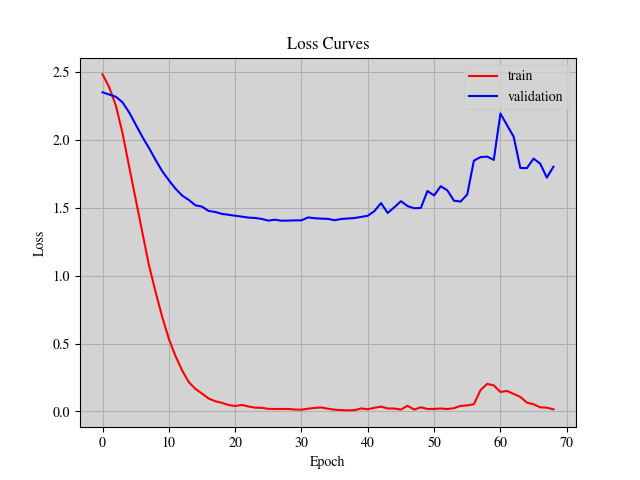

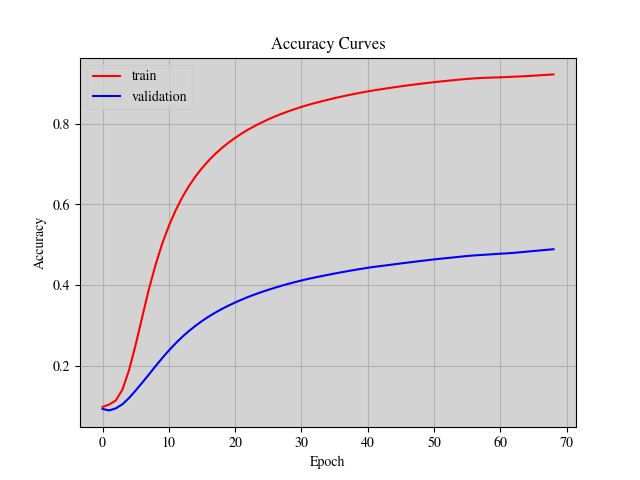

INFO: Seed set to 57516732
INFO:lightning.fabric.utilities.seed:Seed set to 57516732


SemiSupervisedModel


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | arch           | DenseNet           | 7.0 M  | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | test_accuracy  | MulticlassAccuracy | 0      | train
4 | labeling_model | DenseNet           | 7.0 M  | eval 
--------------------------------------------------------------
13.9 M    Train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00044046800000000045 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.000880336 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0013202040000000004 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001760072 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0018000599999999998 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0013601919999999994 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.000920324 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00048045600000000047 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 4.058800000000004e-05 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0004004800000000004 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0008403479999999999 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0012802160000000011 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001720083999999999 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001840048 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0014001800000000004 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0009603120000000009 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005204439999999996 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 8.057600000000008e-05 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0003604919999999995 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0008003600000000008 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0012402280000000001 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0016800959999999996 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0018800360000000007 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0014401679999999995 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0010003 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0005604320000000006 - Epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00012056399999999923 - Epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0003205040000000003 - Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0007603719999999981 - Epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0012002399999999993 - Epoch: 29


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0016401080000000006 - Epoch: 30


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0019200240000000017 - Epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0014801560000000005 - Epoch: 32


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001040287999999999 - Epoch: 33


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006004200000000015 - Epoch: 34


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00016055200000000014 - Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00028051600000000116 - Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0007203839999999989 - Epoch: 37


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001160252 - Epoch: 38


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0016001200000000015 - Epoch: 39


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001960012000000001 - Epoch: 40


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0015201439999999995 - Epoch: 41


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0010802759999999983 - Epoch: 42


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006404080000000006 - Epoch: 43


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0002005399999999993 - Epoch: 44


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00024052799999999845 - Epoch: 45


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006803959999999998 - Epoch: 46


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001120264000000001 - Epoch: 47


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0015601319999999988 - Epoch: 48


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.002 - Epoch: 49


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0015601319999999988 - Epoch: 50


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001120264000000001 - Epoch: 51


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006803959999999998 - Epoch: 52


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00024052799999999845 - Epoch: 53


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0002005399999999993 - Epoch: 54


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006404080000000006 - Epoch: 55


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0010802759999999983 - Epoch: 56


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0015201439999999995 - Epoch: 57


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001960012000000001 - Epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0016001200000000015 - Epoch: 59


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001160252 - Epoch: 60


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0007203839999999989 - Epoch: 61


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.00028051600000000116 - Epoch: 62


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0001605519999999966 - Epoch: 63


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0006004200000000015 - Epoch: 64


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001040287999999999 - Epoch: 65


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.001480156000000004 - Epoch: 66


Validation: |          | 0/? [00:00<?, ?it/s]

[SemiSupervisedModel] Learning Rate Changed: 0.0019200240000000017 - Epoch: 67


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=69` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=69` reached.


[SemiSupervisedModel] Learning Rate Changed: 0.0016401080000000006 - Epoch: 68


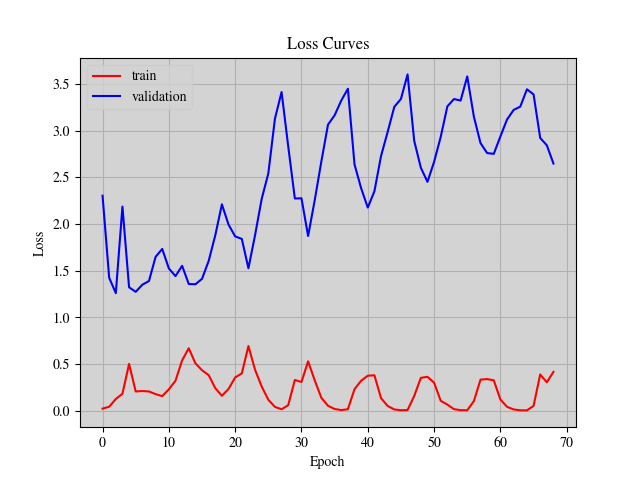

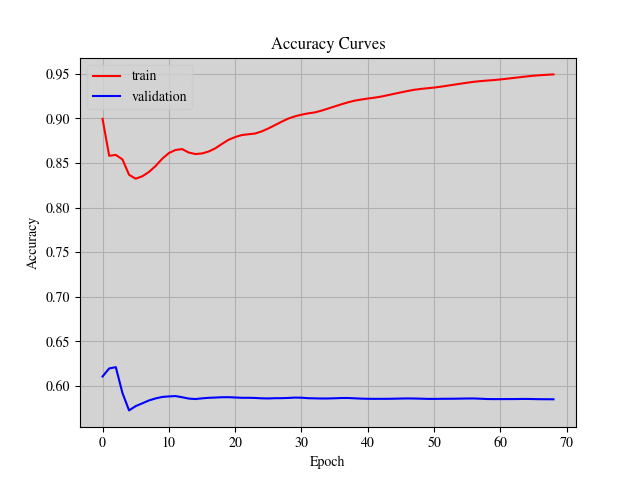

<Figure size 640x480 with 0 Axes>

In [ ]:
def _train_loop(labeling_model):
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)

    try:
        model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)
        model.labeling_model = labeling_model
        model.labeling_model.eval()
        os.remove(BEST_MODEL_PATH)
    except:
        model = MODEL()
        warnings.warn("The weight file does not exist!")

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

    if labeling_model is None:
        return MODEL.load_from_checkpoint(BEST_MODEL_PATH).arch

    return None


labeling_model = None

for _ in range(2):
    labeling_model = _train_loop(labeling_model)

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL(MODEL().arch)
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/SemiSupervisedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/SemiSupervisedModel_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/SemiSupervisedModel_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/model/SemiSupervisedModel_best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6276594996452332     │
│         test_loss         │    1.2740957736968994     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

<Figure size 640x480 with 0 Axes>

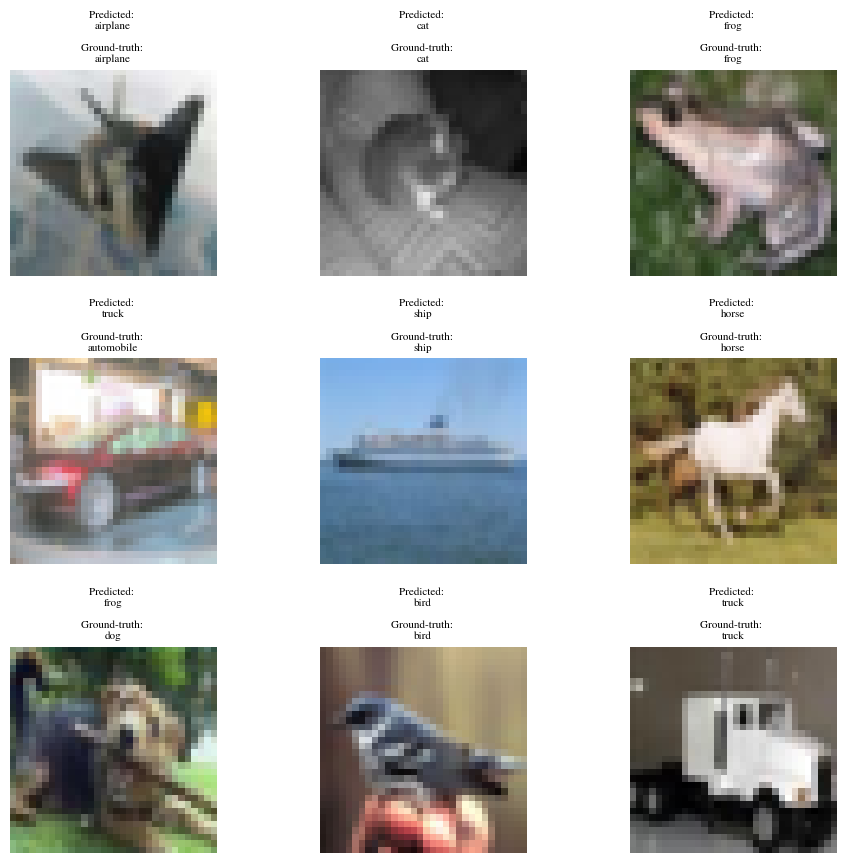

In [ ]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH, labeling_model=MODEL().arch)
model.eval()

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()


for index in range(9):

    while True:
        sample_index = random.randint(0, len(test_dataset) - 1)
        target = test_dataset.classes[test_dataset.targets[sample_index]]

        if target not in class_bin:
            class_bin.append(target)
            break
        else:
            continue

    img_raw = Image.fromarray(test_dataset.data[sample_index])
    img = test_dataset.transform(img_raw).unsqueeze(0).to(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    prediction = model(img)
    prediction = test_dataset.classes[
        torch.argmax(prediction.softmax(1)).data.cpu().numpy()
    ]

    title = f"Predicted: \n{prediction}\n\n"
    title += f"Ground-truth: \n{target}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(img_raw).astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()